# Text metrics

An explanatory notebook to dive into text metrics usuable for a potential DiD.

In [1]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

In [2]:
df = pl.read_parquet("../data/stackoverflow_preprocessed.parquet")

In [3]:
df.columns

['CreationDate',
 'Score',
 'ViewCount',
 'Title',
 'AnswerCount',
 'CommentCount',
 'tag_list',
 'clean_text',
 'code_blocks',
 'tag_count',
 'code_length',
 'body_length',
 'title_length']

## General

In [4]:
df0 = (
    df.filter(pl.col("tag_list").list.contains("c#").not_())
    .with_columns(
        pl.col("CreationDate").cast(pl.Datetime),
        pl.when(pl.col("tag_list").list.contains("python"))
        .then(pl.lit("Python"))
        .when(pl.col("tag_list").list.contains("r"))
        .then(pl.lit("R"))
        .when(pl.col("tag_list").list.contains("php"))
        .then(pl.lit("PHP"))
        .otherwise(pl.lit("JavaScript"))
        .alias("Lang"),
    )
    .with_columns(
        pl.col("CreationDate").dt.date().alias("date"),
        pl.col("CreationDate").dt.year().alias("year"),
        pl.col("CreationDate").dt.month().alias("month"),
        pl.col("CreationDate").dt.weekday().alias("day_of_week"),
        # ISO week of year
        pl.col("CreationDate").dt.week().alias("week"),
    )
    .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
    .group_by(["yearweek", "year", "week"])
    .agg(
        pl.len().alias("question_count"),
        pl.col("date").min().alias("week_start"),
        # Optional: additional metrics if you have them
        pl.col("tag_count").mean().alias("avg_tags"),
        pl.col("code_length").mean().alias("avg_code_length"),
        pl.col("body_length").mean().alias("avg_body_length"),
        pl.col("title_length").mean().alias("avg_title_length"),
    )
    # Normalize (z-score) lengths
    .with_columns(
        (
            (pl.col("avg_tags") - pl.col("avg_tags").mean()) / pl.col("avg_tags").std()
        ).alias("norm_avg_tags"),
        (
            (pl.col("avg_code_length") - pl.col("avg_code_length").mean())
            / pl.col("avg_code_length").std()
        ).alias("norm_avg_code_length"),
        (
            (pl.col("avg_body_length") - pl.col("avg_body_length").mean())
            / pl.col("avg_body_length").std()
        ).alias("norm_avg_body_length"),
        (
            (pl.col("avg_title_length") - pl.col("avg_title_length").mean())
            / pl.col("avg_title_length").std()
        ).alias("norm_avg_title_length"),
    )
    .with_columns(
        # Create a composite score
        (
            pl.col("norm_avg_tags")
            + pl.col("norm_avg_code_length")
            + pl.col("norm_avg_body_length")
            + pl.col("norm_avg_title_length")
        ).alias("score")
    )
)

In [5]:
from datetime import datetime

treatment_date = datetime(2022, 11, 30)

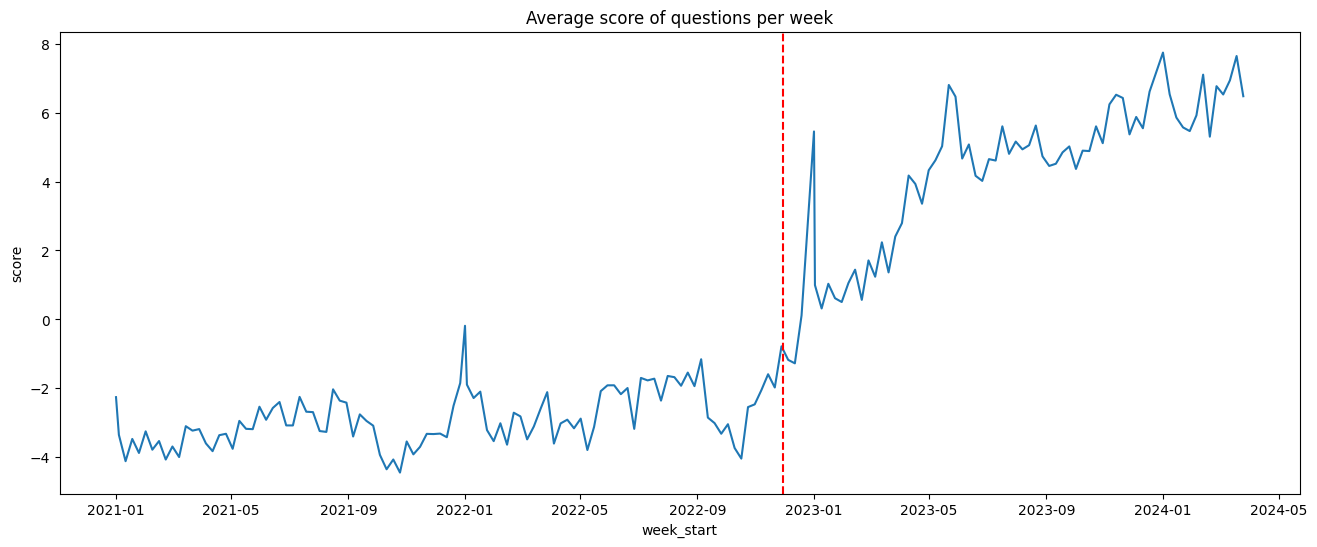

In [6]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="score")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average score of questions per week")
plt.show()

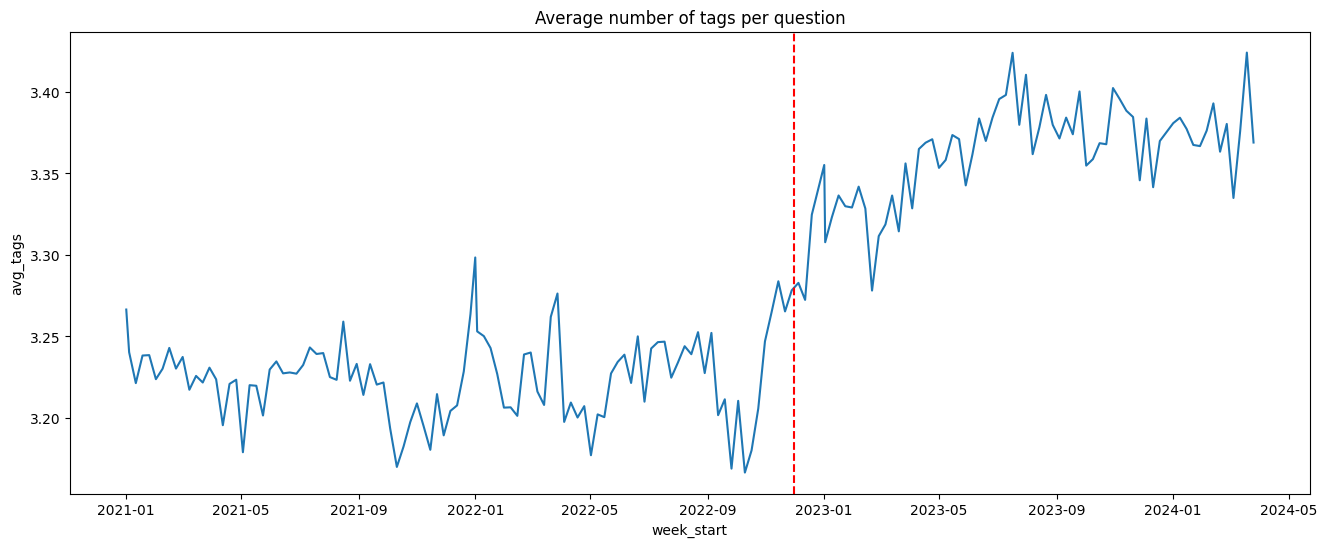

In [7]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="avg_tags")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average number of tags per question")
plt.show()

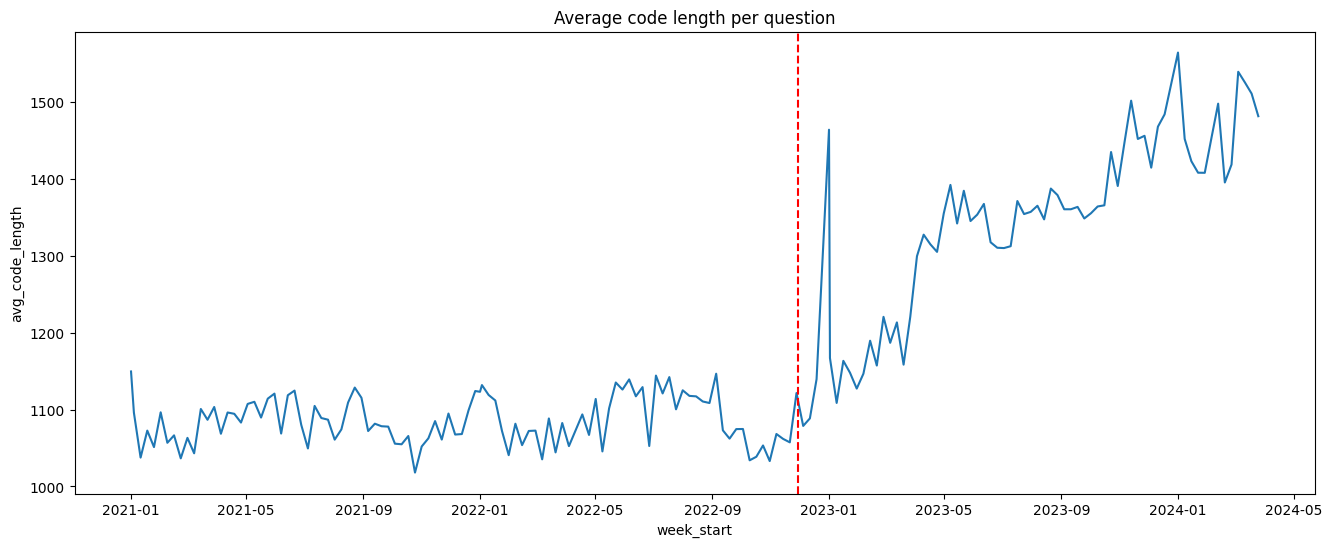

In [8]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="avg_code_length")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average code length per question")
plt.show()

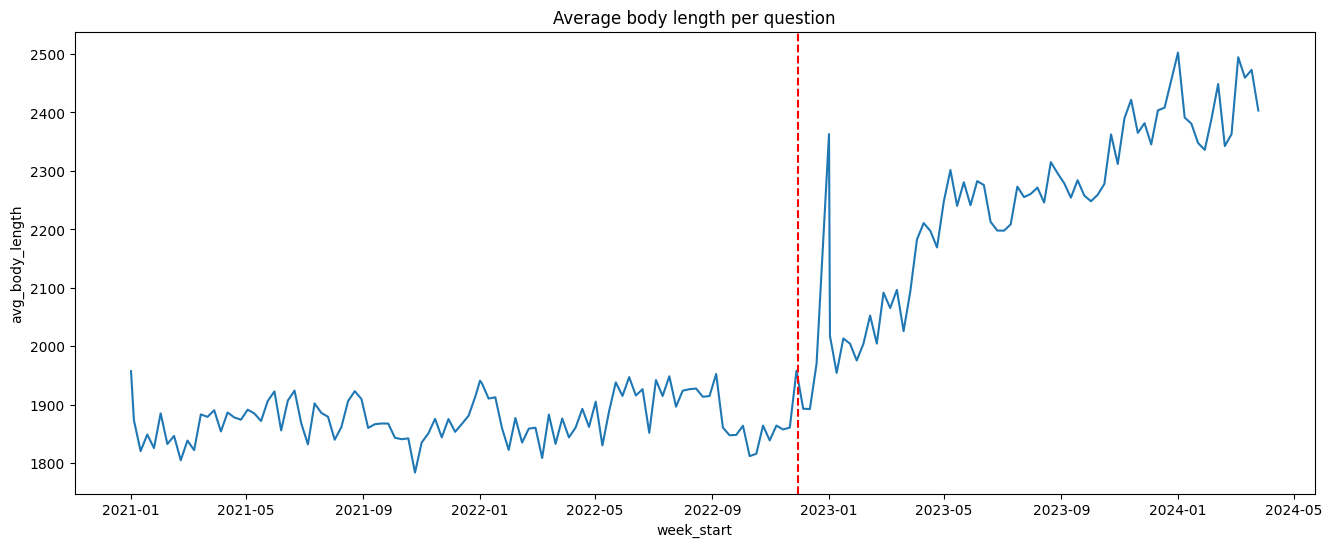

In [9]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="avg_body_length")
# Add a vertical line for ChatGPT release
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average body length per question")
plt.show()

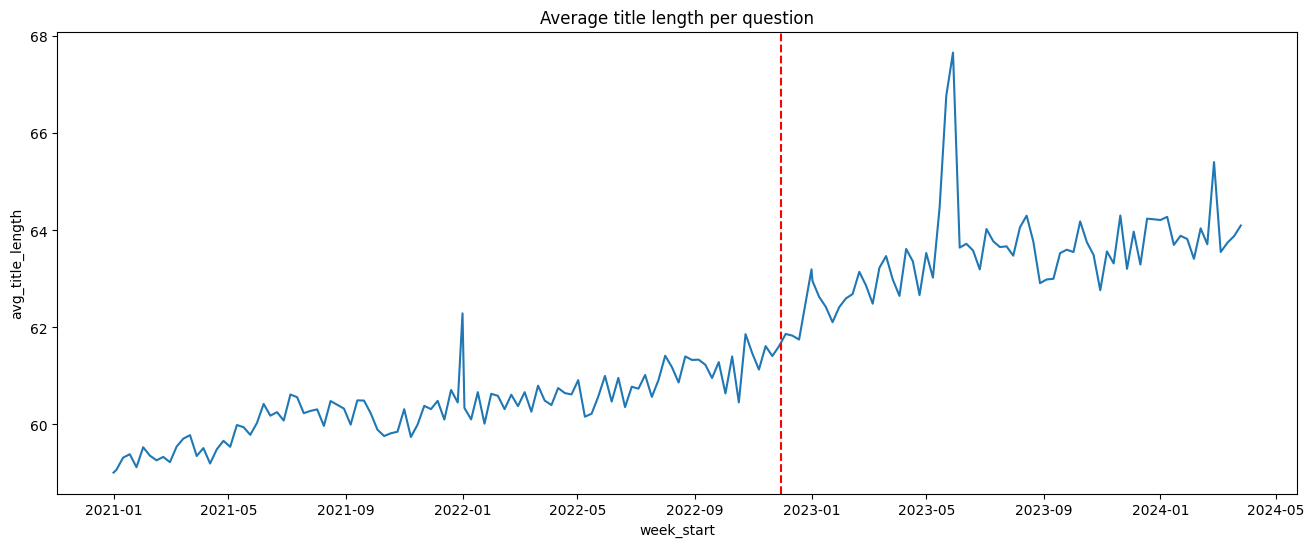

In [10]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df0, x="week_start", y="avg_title_length")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average title length per question")
plt.show()

## By Language

In [11]:
df1 = (
    df.filter(pl.col("tag_list").list.contains("c#").not_())
    .with_columns(
        pl.col("CreationDate").cast(pl.Datetime),
        pl.when(pl.col("tag_list").list.contains("python"))
        .then(pl.lit("Python"))
        .when(pl.col("tag_list").list.contains("r"))
        .then(pl.lit("R"))
        .when(pl.col("tag_list").list.contains("php"))
        .then(pl.lit("PHP"))
        .otherwise(pl.lit("JavaScript"))
        .alias("Lang"),
    )
    .with_columns(
        pl.col("CreationDate").dt.date().alias("date"),
        pl.col("CreationDate").dt.year().alias("year"),
        pl.col("CreationDate").dt.month().alias("month"),
        pl.col("CreationDate").dt.weekday().alias("day_of_week"),
        # ISO week of year
        pl.col("CreationDate").dt.week().alias("week"),
    )
    .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
    .group_by(["yearweek", "year", "week", "Lang"])
    .agg(
        pl.len().alias("question_count"),
        pl.col("date").min().alias("week_start"),
        # Optional: additional metrics if you have them
        pl.col("tag_count").mean().alias("avg_tags"),
        pl.col("code_length").mean().alias("avg_code_length"),
        pl.col("body_length").mean().alias("avg_body_length"),
        pl.col("title_length").mean().alias("avg_title_length"),
    )
    # Normalize lengths to between 0 and 1
    .with_columns(
        (pl.col("avg_tags") / pl.col("avg_tags").max()).alias("norm_avg_tags"),
        (pl.col("avg_code_length") / pl.col("avg_code_length").max()).alias(
            "norm_avg_code_length"
        ),
        (pl.col("avg_body_length") / pl.col("avg_body_length").max()).alias(
            "norm_avg_body_length"
        ),
        (pl.col("avg_title_length") / pl.col("avg_title_length").max()).alias(
            "norm_avg_title_length"
        ),
    )
    .with_columns(
        # Create a composite score
        (
            pl.col("norm_avg_tags")
            + pl.col("norm_avg_code_length")
            + pl.col("norm_avg_body_length")
            + pl.col("norm_avg_title_length")
        ).alias("score")
    )
)

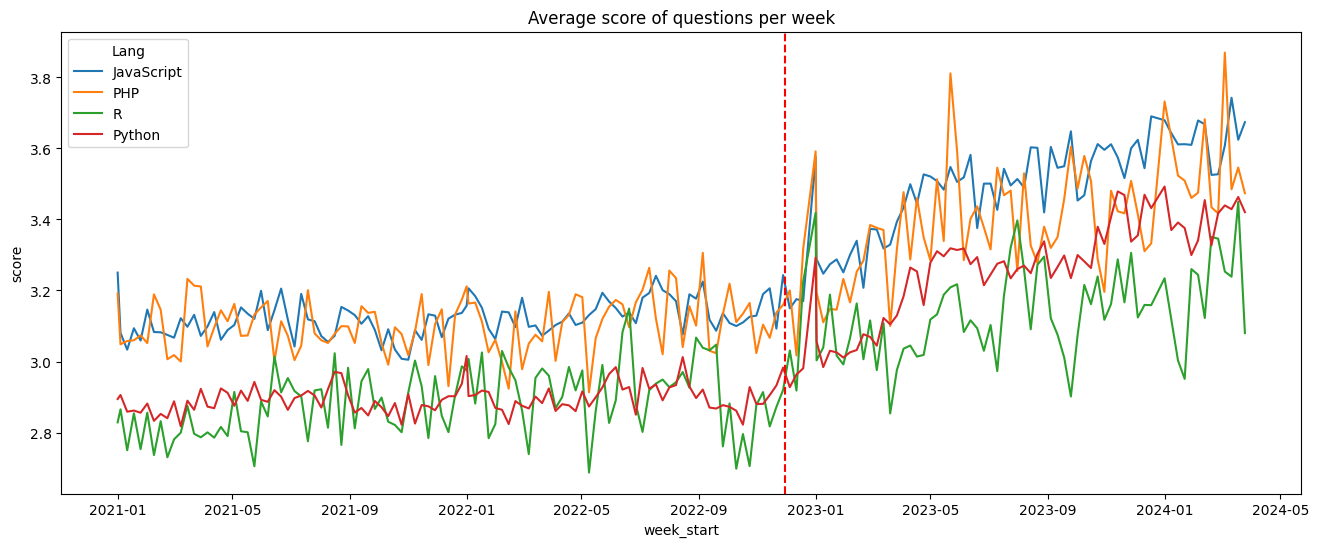

In [12]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="score", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average score of questions per week")
plt.show()

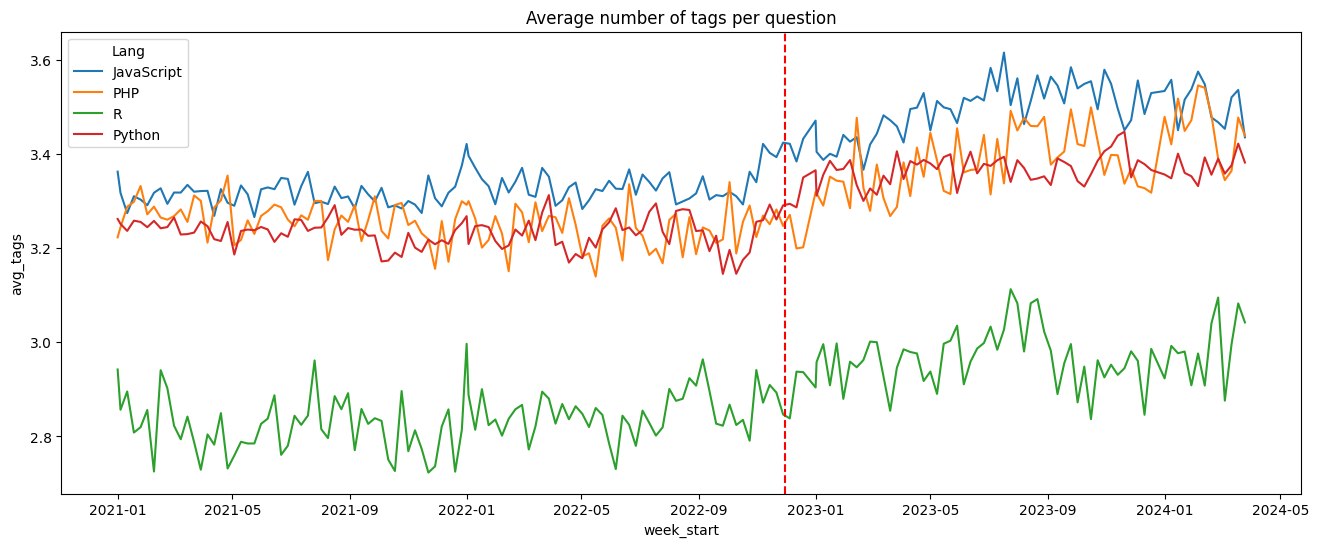

In [13]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="avg_tags", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average number of tags per question")
plt.show()

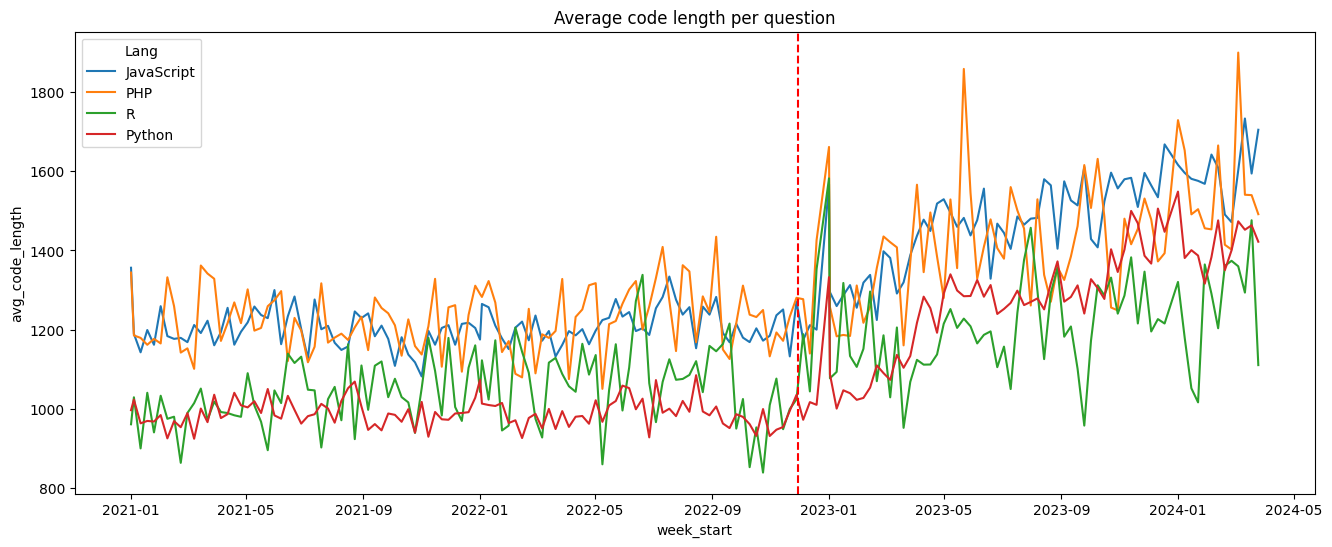

In [14]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="avg_code_length", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average code length per question")
plt.show()

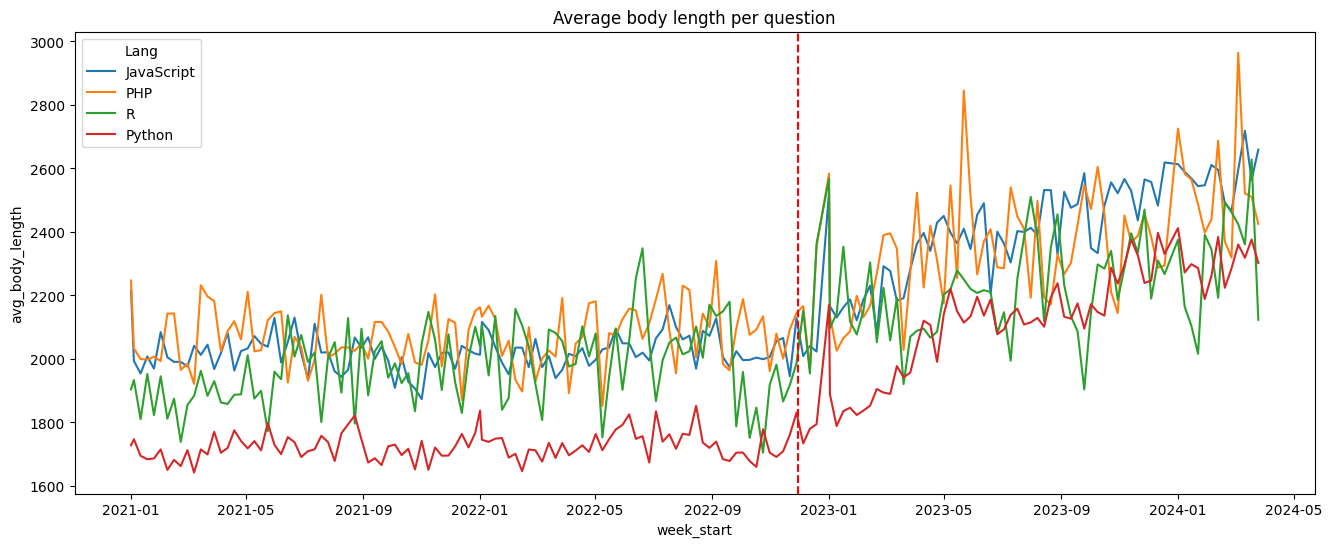

In [15]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="avg_body_length", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average body length per question")
plt.show()

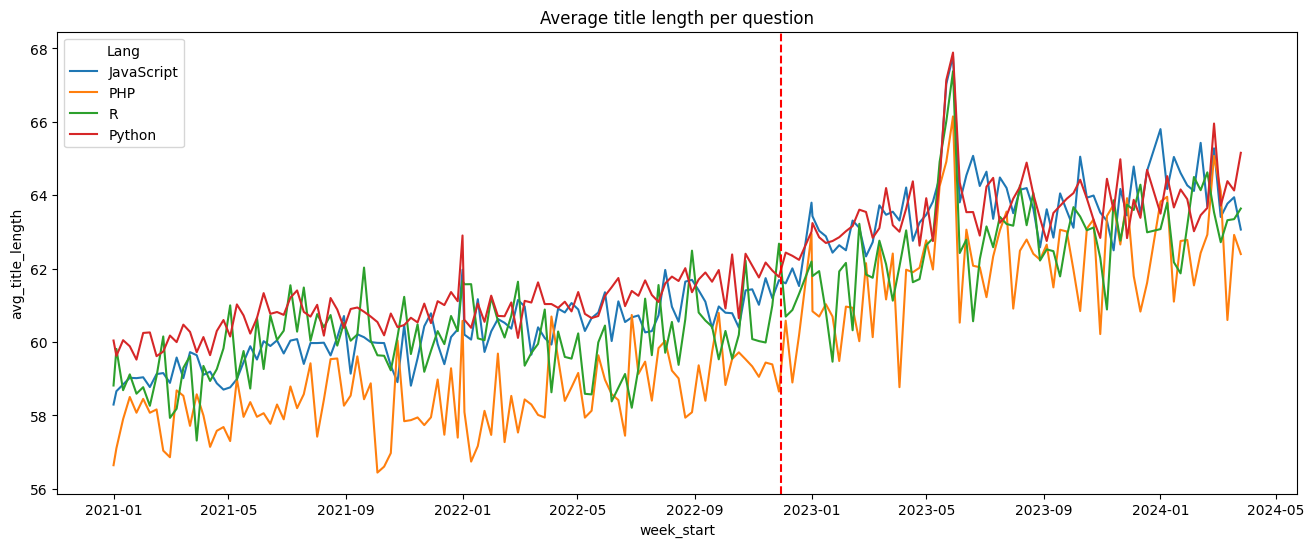

In [16]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df1, x="week_start", y="avg_title_length", hue="Lang")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Average title length per question")
plt.show()

## Comparative metrics for another StackExchange

In [17]:
df_math = pl.read_parquet("../data/math/math.parquet")

In [18]:
df_math.shape

(321580, 21)

In [19]:
df_math1 = (
    df_math.with_columns(
        pl.col("CreationDate").cast(pl.Datetime),
    )
    .with_columns(
        pl.col("CreationDate").dt.date().alias("date"),
        pl.col("CreationDate").dt.year().alias("year"),
        pl.col("CreationDate").dt.month().alias("month"),
        pl.col("CreationDate").dt.weekday().alias("day_of_week"),
        # ISO week of year
        pl.col("CreationDate").dt.week().alias("week"),
        pl.col("Tags")
        .str.strip_prefix("|")
        .str.strip_suffix("|")
        .str.split("|")
        .alias("tag_list"),
    )
    .with_columns(
        (pl.col("year") * 100 + pl.col("week")).alias("yearweek"),
        pl.col("tag_list").list.len().alias("tag_count"),
        pl.col("Body").str.len_chars().alias("body_length"),
        pl.col("Title").str.len_chars().alias("title_length"),
    )
    .group_by(["yearweek", "year", "week"])
    .agg(
        pl.len().alias("question_count"),
        pl.col("date").min().alias("week_start"),
        # Optional: additional metrics if you have them
        pl.col("tag_count").mean().alias("avg_tags"),
        pl.col("body_length").mean().alias("avg_body_length"),
        pl.col("title_length").mean().alias("avg_title_length"),
    )
    # Normalize (z-score) lengths
    .with_columns(
        (
            (pl.col("avg_tags") - pl.col("avg_tags").mean()) / pl.col("avg_tags").std()
        ).alias("norm_avg_tags"),
        (
            (pl.col("avg_body_length") - pl.col("avg_body_length").mean())
            / pl.col("avg_body_length").std()
        ).alias("norm_avg_body_length"),
        (
            (pl.col("avg_title_length") - pl.col("avg_title_length").mean())
            / pl.col("avg_title_length").std()
        ).alias("norm_avg_title_length"),
    )
    .with_columns(
        # Create a composite score
        (
            pl.col("norm_avg_tags")
            + pl.col("norm_avg_body_length")
            + pl.col("norm_avg_title_length")
        ).alias("score")
    )
)

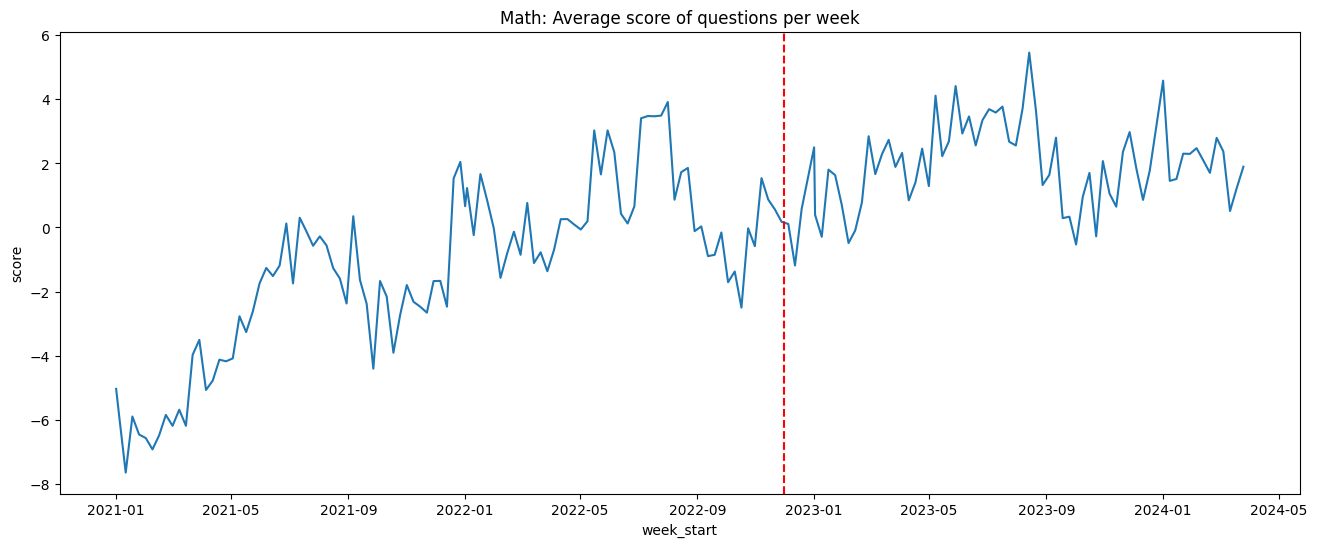

In [20]:
# Line plots of average lengths
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_math1, x="week_start", y="score")
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Math: Average score of questions per week")
plt.show()